# Cryptobuesi

In this project, we will elaborate on different Ensemble Machine Learning methods to predict the price movement of cryptocurrency prices. For that, we use hourly bitcoin (BTC) price data from Binance and write our own trading bot that interacts with Binance and does the buying and selling for us. 

For now, I am not going to show all the Ensemble methods that I have tried out because they are too many. However, the book `George Kyriakides. “Hands-On Ensemble Learning with Python.”` contains a good overview of some Ensemble methods (e.g., voting, stacking, bagging and boosting) that you can start out with. The code presented below is also largely inspired by this work.

I am also not showing the full code for the trading bot implementation, but will only provide some rough overview over the key functions in another notebook. 

*Note that the name "Cryptobuesi" is the name of the trading bot. "Buesi" is a Swiss German word for cat.*

In [37]:
import numpy as np
import datetime
import re
import pandas as pd
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from copy import deepcopy
from xgboost import XGBRegressor

# Load hourly bitcoin data from Binance

To get the binance data, you can use this code snippet below. You need access to the Binance API, which means that you need to register there. There exists a lot of information on how to do this, so I am not going to spend time on this part here.

In [38]:
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

# uncomment to receive hourly data
# get_all_binance("BTCUSDT", "1h", save=True)

Let's load our preloaded data from Binance.

In [39]:
data = pd.read_csv(f'../02.Prepared_data/cryptobuesi/BTCUSDT-1h-data.csv')

## Data exploration and cleaning

I am not explaining the Binance dataset here, because you find so much information on it from the Binance API documentation. I recommend you to read through this. In short, we are interested in the hourly closing price of the cryptocurrency and do not care about the rest of the columns with the exception of the timestamp.

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32557 entries, 0 to 32556
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    32557 non-null  object 
 1   open         32557 non-null  float64
 2   high         32557 non-null  float64
 3   low          32557 non-null  float64
 4   close        32557 non-null  float64
 5   volume       32557 non-null  float64
 6   close_time   32557 non-null  int64  
 7   quote_av     32557 non-null  float64
 8   trades       32557 non-null  int64  
 9   tb_base_av   32557 non-null  float64
 10  tb_quote_av  32557 non-null  float64
 11  ignore       32557 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 3.0+ MB


In [41]:
data.shape

(32557, 12)

In [42]:
data.dropna().shape

(32557, 12)

It seems that we do not have any null rows.

In [43]:
data.head()

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,150952.477943,7887.635513
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,92608.279728,8039.262402
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,20795.317224,8041.760498
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,1502956799999,19241.058300,25,2.602292,11291.347015,8048.127886
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.503586,28,0.814655,3552.746817,8018.036500


In [44]:
data = data.dropna()
data['date'] = pd.to_datetime(data['timestamp'])
data.head()

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,date
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,150952.477943,7887.635513,2017-08-17 04:00:00
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,92608.279728,8039.262402,2017-08-17 05:00:00
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,20795.317224,8041.760498,2017-08-17 06:00:00
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,1502956799999,19241.058300,25,2.602292,11291.347015,8048.127886,2017-08-17 07:00:00
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.503586,28,0.814655,3552.746817,8018.036500,2017-08-17 08:00:00


In [45]:
data = data.set_index('date', drop=True)

In [46]:
data.head(5)

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
date,,,,,,,,,,,,
2017-08-17 04:00:00,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,150952.477943,7887.635513
2017-08-17 05:00:00,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,92608.279728,8039.262402
2017-08-17 06:00:00,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,20795.317224,8041.760498
2017-08-17 07:00:00,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,1502956799999,19241.058300,25,2.602292,11291.347015,8048.127886
2017-08-17 08:00:00,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.503586,28,0.814655,3552.746817,8018.036500


## Prediction target


For our purpose of forecasting, we want to predict the percentage change in the price from one timestamp to the next:

$$\textrm{pct_change} = \frac{p_n-p_{n-1}}{p_{n-1}}$$

where $p$ is the price of the cryptocurrency. This is a readily available method in pandas.

In [47]:
# diffs = (data['close'].diff()/data['close']).values[1:] # percentage differences of close values

# diff_len = len(diffs)

In [48]:
#  diffs

In [49]:
df_diff = data['close'].pct_change().dropna()
diffs = df_diff.values
diff_len = len(diffs)
diffs

array([ 0.00150621,  0.00209254,  0.00592921, ..., -0.00085844,
        0.00365011,  0.00420533])

As features for our prediction, we use the percentage changes for previous lags, so we shift the dataset forward by as many datapoints according to the lag. We also include the simple moving average of past prices to consider as features. 

In [18]:
def create_x_data(lags=1):
    diff_data = np.zeros((diff_len, lags))
    ma_data = np.zeros((diff_len, lags))
    
    # consider also the simple moving average
    diff_ma = df_diff.rolling(15*24).mean().fillna(0).values[:]
    for lag in range(1, lags+1):
        this_data = diffs[:-lag]
        diff_data[lag:, lag-1] = this_data

        this_data = diff_ma[:-lag]
        ma_data[lag:, lag-1] = this_data
        
    return np.concatenate((diff_data, ma_data), axis=1)

# REPRODUCIBILITY
nlags = 24*10 # data is in intervals of 1 h, take the past 10 days as features
x_data = create_x_data(lags=nlags)*100 
y_data = diffs*100
y_data = np.round(y_data, 10) # round to prevent overflow errors

In [50]:
df_diff = df_diff*100
df_diff = np.round(df_diff, 10)

## Walk-forward validation

Let's take a training window of 100 days to predict the next hour of price. It does probably make sense to include more datapoints in the walk-forward validation, but this will come at computational cost. If we chose a too small dataset, we provide too little data. And on the other hand a too large dataset would reflect market conditions that are not representative of reality any more. Regardless, we measure the predictive quality using the root mean squared error between the predictions and the original percentage differences in the training set.

We are using walk forward validation instead of a fixed train test split (i.e., first x month train, last n-x months as test) because this would bias our model to the most recent timestamps. This is not necessarily what we want. This set up of walk forward validation can also be used in a cross validation sense, but we are not evaluating this here (e.g., for hyperparameter optimization). Technically, this is not a fair representation of our model. We should evaluate the model on completely unseen data to get an idea how it would perform in the real world. In the current state of this project, we do not worry about that.

In [25]:
# walk forward validation window size
window = 100*24
window

2400

# Boosting loop


Here we run the walk forward validation loop.

In [24]:
lr = XGBRegressor(n_jobs=5, max_depth=2, n_estimators=10, reg_alpha=0.5)

preds = []
starts = []
ends = []
ts_preds = []
start_time = datetime.datetime.now()
for i in range(diff_len-window-1):
    if (i % 100 == 0):
        time_elapsed = datetime.datetime.now() - start_time
        print(f"I am at loop {i} out of {diff_len-window-1} :::: Seconds since start: {time_elapsed.seconds}")
    # start and end timestamp of the window used for prediction
    start = df_diff.index[i]
    end = df_diff.index[i+window]
    starts.append(start)
    ends.append(end)

    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    pred = lr.predict(x_data[i+window+1, :].reshape(1, -1)) # predict the next hour
    ts_prediction = df_diff.index[i+window+1]# timestamp of the prediction
    preds.append(pred[0])
    ts_preds.append(ts_prediction)
    
df_prediction = pd.DataFrame({'ts_start': starts, 'ts_end': ends, 'ts_prediction': ts_preds, 'prediction': preds})
del preds
del starts
del ts_preds
del ends

I am at loop 0 out of 30155 :::: Seconds since start: 0
I am at loop 100 out of 30155 :::: Seconds since start: 7
I am at loop 200 out of 30155 :::: Seconds since start: 14
I am at loop 300 out of 30155 :::: Seconds since start: 22
I am at loop 400 out of 30155 :::: Seconds since start: 30
I am at loop 500 out of 30155 :::: Seconds since start: 37
I am at loop 600 out of 30155 :::: Seconds since start: 45
I am at loop 700 out of 30155 :::: Seconds since start: 52
I am at loop 800 out of 30155 :::: Seconds since start: 60
I am at loop 900 out of 30155 :::: Seconds since start: 68
I am at loop 1000 out of 30155 :::: Seconds since start: 76
I am at loop 1100 out of 30155 :::: Seconds since start: 83
I am at loop 1200 out of 30155 :::: Seconds since start: 91
I am at loop 1300 out of 30155 :::: Seconds since start: 99
I am at loop 1400 out of 30155 :::: Seconds since start: 107
I am at loop 1500 out of 30155 :::: Seconds since start: 115
I am at loop 1600 out of 30155 :::: Seconds since st

I am at loop 13500 out of 30155 :::: Seconds since start: 1069
I am at loop 13600 out of 30155 :::: Seconds since start: 1077
I am at loop 13700 out of 30155 :::: Seconds since start: 1085
I am at loop 13800 out of 30155 :::: Seconds since start: 1093
I am at loop 13900 out of 30155 :::: Seconds since start: 1101
I am at loop 14000 out of 30155 :::: Seconds since start: 1109
I am at loop 14100 out of 30155 :::: Seconds since start: 1117
I am at loop 14200 out of 30155 :::: Seconds since start: 1125
I am at loop 14300 out of 30155 :::: Seconds since start: 1133
I am at loop 14400 out of 30155 :::: Seconds since start: 1140
I am at loop 14500 out of 30155 :::: Seconds since start: 1148
I am at loop 14600 out of 30155 :::: Seconds since start: 1156
I am at loop 14700 out of 30155 :::: Seconds since start: 1164
I am at loop 14800 out of 30155 :::: Seconds since start: 1172
I am at loop 14900 out of 30155 :::: Seconds since start: 1180
I am at loop 15000 out of 30155 :::: Seconds since star

I am at loop 26600 out of 30155 :::: Seconds since start: 2116
I am at loop 26700 out of 30155 :::: Seconds since start: 2124
I am at loop 26800 out of 30155 :::: Seconds since start: 2132
I am at loop 26900 out of 30155 :::: Seconds since start: 2140
I am at loop 27000 out of 30155 :::: Seconds since start: 2148
I am at loop 27100 out of 30155 :::: Seconds since start: 2156
I am at loop 27200 out of 30155 :::: Seconds since start: 2164
I am at loop 27300 out of 30155 :::: Seconds since start: 2172
I am at loop 27400 out of 30155 :::: Seconds since start: 2180
I am at loop 27500 out of 30155 :::: Seconds since start: 2187
I am at loop 27600 out of 30155 :::: Seconds since start: 2195
I am at loop 27700 out of 30155 :::: Seconds since start: 2203
I am at loop 27800 out of 30155 :::: Seconds since start: 2211
I am at loop 27900 out of 30155 :::: Seconds since start: 2219
I am at loop 28000 out of 30155 :::: Seconds since start: 2227
I am at loop 28100 out of 30155 :::: Seconds since star

In [25]:
df_prediction

,ts_start,ts_end,ts_prediction,prediction
0,2017-08-17 05:00:00,2017-11-25 12:00:00,2017-11-25 13:00:00,-0.004647
1,2017-08-17 06:00:00,2017-11-25 13:00:00,2017-11-25 14:00:00,-0.001852
2,2017-08-17 07:00:00,2017-11-25 14:00:00,2017-11-25 15:00:00,0.070337
3,2017-08-17 08:00:00,2017-11-25 15:00:00,2017-11-25 16:00:00,-0.002359
4,2017-08-17 09:00:00,2017-11-25 16:00:00,2017-11-25 17:00:00,-0.002308
...,...,...,...,...
30150,2021-01-29 04:00:00,2021-05-09 11:00:00,2021-05-09 12:00:00,-0.019067
30151,2021-01-29 05:00:00,2021-05-09 12:00:00,2021-05-09 13:00:00,0.648798
30152,2021-01-29 06:00:00,2021-05-09 13:00:00,2021-05-09 14:00:00,-0.019877
30153,2021-01-29 07:00:00,2021-05-09 14:00:00,2021-05-09 15:00:00,-0.009452


# Evaluation

I have run the walk forward validation for a range of feature parameters:

Number of data points for the simple moving average:
`rolling_windows = [x*24 for x in [10, 20, 50] ]` <br>

Number of lags to consider as features:
`list_nlags = [x* 24 for x in [10, 20, 50]]`

Let's now evaluate these models in terms of their root mean squared error and how they would perform in a real trading scenario (backtesting). The problem with backtesting is that the performance is evaluated on the dataset that was also used for training. This constitutes a data leakage problem, but due to the nature of this problem, we have no other option to go with. As another evaluation metric, we are using the Sharpe ratio which is the ratio of the expected return divided by the volatility. We approximate this by considering the average profits divided by the standard deviation of the profits.

I have already run the simulation (see `simulator.py`) where we take 100 USD at the beginning of the time series and sell every time the predicted price movement is larger than -0.5%. We then buy if the predicted price goes up by more than 0.5%. The code never sells below the buying price, except after some dump period after which we cut our losses. This must be further evaluated. But for now, it will be what we go with.

In [26]:
# path to where the results are stored
path = '../02.Prepared_data/cryptobuesi/'
full_paths = [f"{path}{x}" for x in os.listdir(path) if 'RESULT' in x]

# extract parameters from the filename
IDs = np.arange(len(full_paths))
nlags = [re.findall(r'nlags(\d+)_', x)[0] for x in full_paths]
rolllingma = [re.findall(r'rollingma(\d+)', x)[0] for x in full_paths]
df_param = pd.DataFrame({'ID': IDs, 'fname': full_paths, 'nlags': nlags, 'rolllingma': rolllingma})
df_param.set_index('ID', inplace=True)

In [27]:
df_param

,fname,nlags,rolllingma
ID,,,
0,../02.Prepared_data/cryptobuesi/RESULT_XGBoost...,1200,480
1,../02.Prepared_data/cryptobuesi/RESULT_XGBoost...,1200,240
2,../02.Prepared_data/cryptobuesi/RESULT_XGBoost...,480,1200
3,../02.Prepared_data/cryptobuesi/RESULT_XGBoost...,480,480
4,../02.Prepared_data/cryptobuesi/RESULT_XGBoost...,480,240
5,../02.Prepared_data/cryptobuesi/RESULT_XGBoost...,1200,1200
6,../02.Prepared_data/cryptobuesi/RESULT_XGBoost...,240,480
7,../02.Prepared_data/cryptobuesi/RESULT_XGBoost...,240,1200
8,../02.Prepared_data/cryptobuesi/RESULT_XGBoost...,240,240


In [28]:
for fname in df_param['fname'].values.tolist():
    df_prediction = pd.read_csv(fname, index_col=0, parse_dates=True)    
    print(fname)
    print(df_prediction)



../02.Prepared_data/cryptobuesi/RESULT_XGBoost_window2400_ma_nlags1200_rollingma480.csv
      Profits  Dump days   Model      rmse    sharpe
0  568.384933          2  voting  0.981397  0.144181
1  369.225268          5  voting  0.981397  0.120387
2  821.146679         15  voting  0.981397  0.192477
3  477.930353         30  voting  0.981397  0.242686
4  443.756872         60  voting  0.981397  0.277268
5  278.894044        120  voting  0.981397  0.239953
../02.Prepared_data/cryptobuesi/RESULT_XGBoost_window2400_ma_nlags1200_rollingma240.csv
      Profits  Dump days   Model      rmse    sharpe
0  293.056604          2  voting  0.982505  0.116079
1  252.202002          5  voting  0.982505  0.155447
2  280.125366         15  voting  0.982505  0.144198
3  539.673040         30  voting  0.982505  0.332884
4  348.046117         60  voting  0.982505  0.290082
5  468.907584        120  voting  0.982505  0.388207
../02.Prepared_data/cryptobuesi/RESULT_XGBoost_window2400_ma_nlags480_rollingma120

From this, we see that nlags1200 and rollingma1200 performed best with profits beyond 1000 USD. Let us run this model again. 

In [ ]:
nlags = 1200
rolling_window = 1200

def create_x_data(lags=1, rolling_window=1000):
    # rolling_window: rolling mean in hours
    diff_data = np.zeros((diff_len, lags))
    ma_data = np.zeros((diff_len, lags))

    diff_ma = df_diff.rolling(rolling_window).mean().fillna(0).values[:]
    for lag in range(1, lags+1):
        this_data = diffs[:-lag]
        diff_data[lag:, lag-1] = this_data

        this_data = diff_ma[:-lag]
        ma_data[lag:, lag-1] = this_data

    return np.concatenate((diff_data, ma_data), axis=1)


# REPRODUCIBILITY
# nlags = 24*20 # data is in intervals of 1 h, take the past 20 days as features
x_data = create_x_data(lags=nlags, rolling_window=rolling_window)*100
y_data = diffs*100
y_data = np.round(y_data, 10) # round to prevent overflow errors
df_diff = df_diff*100
df_diff = np.round(df_diff, 10)

# Boosting loop

lr = XGBRegressor(n_jobs=5, max_depth=2, n_estimators=10, reg_alpha=0.5)

preds = []
starts = []
ends = []
ts_preds = []
start_time = datetime.now()
for i in range(diff_len-window-1):
    if (i % 100 == 0):
        time_elapsed = datetime.now() - start_time
        print(f"I am at loop {i} out of {diff_len-window-1} :::: Seconds since start: {time_elapsed.seconds}")
    # start and end timestamp of the window used for prediction
    start = df_diff.index[i]
    end = df_diff.index[i+window]
    starts.append(start)
    ends.append(end)

    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    pred = lr.predict(x_data[i+window+1, :].reshape(1, -1)) # predict the next hour
    ts_prediction = df_diff.index[i+window+1]# timestamp of the prediction
    preds.append(pred[0])
    ts_preds.append(ts_prediction)

df_prediction = pd.DataFrame({'ts_start': starts, 'ts_end': ends, 'ts_prediction': ts_preds, 'prediction': preds})
del preds
del starts
del ts_preds
del ends

In [33]:
df_prediction = pd.read_csv('../02.Prepared_data/cryptobuesi/XGBoost_window2400_ma_nlags1200_rollingma1200.csv', parse_dates=True, index_col=0)
for c in df_prediction.columns:
    if 'ts' in c:
        df_prediction[c] = pd.to_datetime(df_prediction[c])
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30155 entries, 0 to 30154
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ts_start       30155 non-null  datetime64[ns]
 1   ts_end         30155 non-null  datetime64[ns]
 2   ts_prediction  30155 non-null  datetime64[ns]
 3   prediction     30155 non-null  float64       
dtypes: datetime64[ns](3), float64(1)
memory usage: 1.2 MB


# RMSE and simulate

Let us run the trading bot simulation again.

## RMSE

In [51]:
prediction = df_prediction[['ts_prediction', 'prediction', 'ts_end']].set_index('ts_prediction')
y_true = df_diff.loc[prediction.index].values
y_pred = prediction['prediction'].values
rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
rmse

0.9820739556540032

In [53]:
y_true.mean()

0.010767699098239098

In comparison with the true man values, the RMSE is high, but we can still use it to compare different models. 

## Simulate

Here we simulate the trading bot. It can happen that the bot buys at a local maximum and then will seize to trade for an extended period which is undesired. Hence, I added some "dump" time, which means that after a certain amount of days, the bot evaluates again if trading is worth it. This might expose the bot to the risk of losing money, though and it should be carefully evaluated. 

In [55]:
from simulator import simulate

In [64]:
# Constants and placeholders
buy_threshold = 0.5 # above or below which percentage to buy or sell
balance = 100 # how much dollar we are starting out with
dump_time = 20

balance, buy_points, sell_points, dump_points, profits = simulate(data, prediction, buy_threshold, balance, dump_time)

Text(0.5, 1.0, 'Backtesting the Cryptobuesi trading bot on BTC')

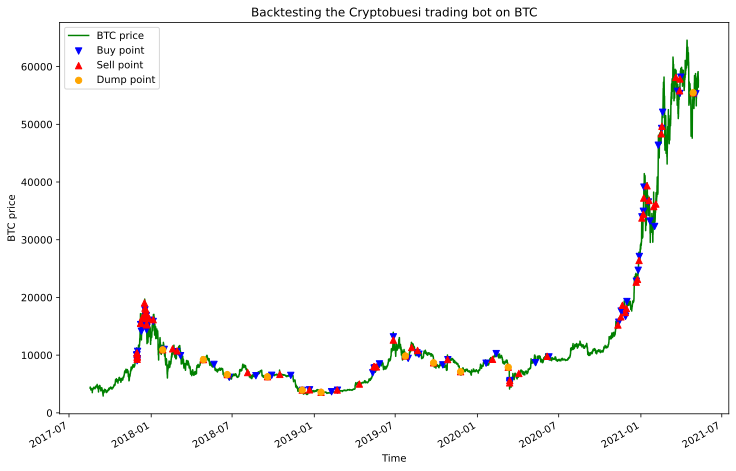

In [77]:
data['close'].plot(figsize=(12,8), color='green', legend=True, label='BTC price')
# xlims = plt.gca().get_xlim()
# ylims = plt.gca().get_ylim()
plt.scatter(data.loc[buy_points, 'close'].index, data.loc[buy_points, 'close'].values, marker='v',
            c='blue', s=40, zorder=10, label='Buy point')
plt.scatter(data.loc[sell_points, 'close'].index, data.loc[sell_points, 'close'].values, marker='^',
            c='red', s=40, zorder=10, label='Sell point')
plt.scatter(data.loc[dump_points, 'close'].index, data.loc[dump_points, 'close'].values, marker='o',
            c='orange', s=40, zorder=10, label='Dump point')
plt.legend()
plt.savefig('btc_backtesting.png', dpi=600)
plt.xlabel('Time')
plt.ylabel('BTC price')
plt.title("Backtesting the Cryptobuesi trading bot on BTC")
# plt.xlim(xlims)
# plt.ylim(ylims)

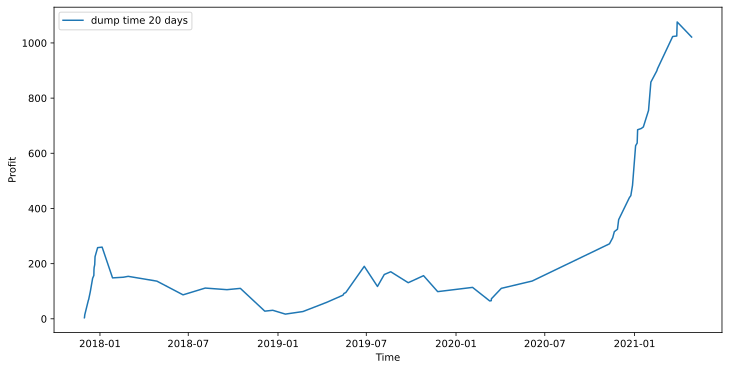

In [71]:
fig = plt.figure(figsize=(12,6))
plt.plot(data.loc[sell_points, 'close'].index, np.cumsum(profits), label=f"dump time {dump_time} days")
plt.ylabel('Profit')
plt.xlabel('Time')
plt.legend()
plt.show()

We see that the bot would have performed very well because of the 2021 bull run. However, between the accumulation phases between 2018 and 2020, it would not have done well and kept the portfolio around 200 USD.

It makes sense to expand this analysis also for other cryptocurrencies.